In [4]:

import pandas as pd
import seaborn as sn

# Data import and analysis

In [5]:
df = pd.read_csv("reviews_df.csv")
df.head()

,0,1
0,True,"Savršeno! U samom centru grada. Dobre cijene, ..."
1,True,Godišnja klubska skupština BK Sljeme. Pozdrav ...
2,True,Hrana je izuzetno fina i ima okus kao da je sv...
3,True,"Odlična kava 😃☕, mirno mjesto, kao i vrlo ljub..."
4,True,Hvala ekipi iz Cvjetnog objekta Žirafa večeras...


# True - rating is positive, False - rating is negativ

In [6]:
df = df.rename(columns={'0': 'rating', '1':'comment'})

In [8]:
df.columns

Index(['rating', 'comment'], dtype='object')

c:\Users\Ivana\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

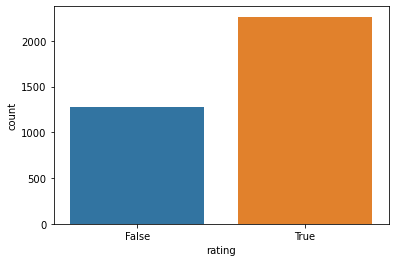

In [9]:
sn.countplot(df.rating)

In [15]:
df.rating.value_counts()

True     2265
False    1279
Name: rating, dtype: int64

In [19]:
df['rating_num'] = df.rating.map({True:1, False:0})

In [20]:
df.head()

,rating,comment,rating_num
0,True,"Savršeno! U samom centru grada. Dobre cijene, ...",1
1,True,Godišnja klubska skupština BK Sljeme. Pozdrav ...,1
2,True,Hrana je izuzetno fina i ima okus kao da je sv...,1
3,True,"Odlična kava 😃☕, mirno mjesto, kao i vrlo ljub...",1
4,True,Hvala ekipi iz Cvjetnog objekta Žirafa večeras...,1


In [21]:
df.groupby('rating_num').describe()

rating                     comment         \
            count unique    top  freq   count unique   
rating_num                                             
0            1279      1  False  1279    1279   1258   
1            2265      1   True  2265    2265   2227   

                                                                    
                                                          top freq  
rating_num                                                          
0           Hrana zbilja dobra, ima prostora i za mali nap...    2  
1           Ovdje ćete ukusno pojesti i jako malo platiti,...    2

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.comment,
    df.rating_num,
    stratify=df.rating_num
)

In [23]:
X_train.head()

2665    Odličan pivski gulaš, fino pivo, jako ljubazno...
2978    Savrsen ugođaj, ljubszno osoblje, ambijent sup...
3228    Ambijent fin, ali usluga čisti prosjek. Hrana ...
1923    Super usluga, a hrana da ne pricam, preukusna....
2387    predugo čekanje i mali prostor ispred kasa...d...
Name: comment, dtype: object

### Import tensorflow for BERT

In [24]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [27]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [28]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [30]:
get_sentence_embeding([df.comment[1]])

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.63758415, -0.41848284, -0.99432737,  0.82620454,  0.85842806,
        -0.266385  ,  0.73144984,  0.4130124 , -0.9601587 , -0.999937  ,
        -0.61279243,  0.9715844 ,  0.8172495 ,  0.8336045 ,  0.45702103,
        -0.84297395, -0.5567209 , -0.5748343 ,  0.27769238,  0.20088291,
         0.6843097 ,  1.        , -0.6994725 ,  0.38570243,  0.3279886 ,
         0.9929638 , -0.6896063 ,  0.48976862,  0.79821587,  0.30568045,
        -0.61686116,  0.25196865, -0.9023649 , -0.22141927, -0.9971601 ,
        -0.9478164 ,  0.40773213, -0.21895239, -0.09621991, -0.22255601,
        -0.6089841 ,  0.2796304 ,  0.9999733 ,  0.62655985,  0.5174335 ,
        -0.18519929, -1.        ,  0.481638  , -0.48840997,  0.98653674,
         0.9798135 ,  0.9819985 ,  0.27228317,  0.3835268 ,  0.504712  ,
        -0.6939012 , -0.07220121,  0.13945596, -0.18971175, -0.48235998,
        -0.5153407 ,  0.60195553, -0.9811838 , -0.64527804,  0.9776733 ,
 

### Building Tensorflow model


In [32]:
### Bert layers with input & output

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network Layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name = 'output')(l)

# final Model with inputs & outputs
model = tf.keras.Model(inputs=[text_input], outputs= [l])

In [33]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [34]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
84/84 [==============================] - 875s 10s/step - loss: 0.6757 - accuracy: 0.6117 - precision: 0.6372 - recall: 0.9117
Epoch 2/10
84/84 [==============================] - 825s 10s/step - loss: 0.6558 - accuracy: 0.6336 - precision: 0.6484 - recall: 0.9323
Epoch 3/10
84/84 [==============================] - 851s 10s/step - loss: 0.6463 - accuracy: 0.6309 - precision: 0.6507 - recall: 0.9123
Epoch 4/10
84/84 [==============================] - 906s 11s/step - loss: 0.6392 - accuracy: 0.6445 - precision: 0.6602 - recall: 0.9147
Epoch 5/10
84/84 [==============================] - 840s 10s/step - loss: 0.6345 - accuracy: 0.6531 - precision: 0.6681 - recall: 0.9088
Epoch 6/10
84/84 [==============================] - 980s 12s/step - loss: 0.6302 - accuracy: 0.6464 - precision: 0.6673 - recall: 0.8911
Epoch 7/10
84/84 [==============================] - 975s 12s/step - loss: 0.6217 - accuracy: 0.6546 - precision: 0.6732 - recall: 0.8935
Epoch 8/10
84/84 [=======================

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
y_test[1]

1

In [42]:
y_test.shape

(886,)

In [37]:
y_pred = model.predict(X_test)


28/28 [==============================] - 701s 24s/step


In [43]:
y_pred.shape

(886, 1)

In [1]:
import numpy as np

y_pred = np.where(y_pred > 0.5, 1, 0)

NameError: name 'y_pred' is not defined

In [46]:
y_pred[1]

array([0])

[[ 76 244]
 [ 33 533]]


Text(33.0, 0.5, 'Truth')

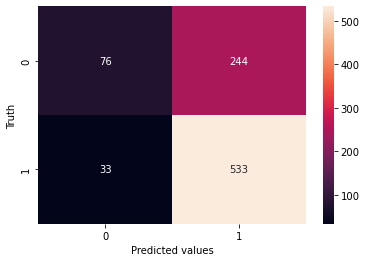

In [47]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

import seaborn as sn
from matplotlib import pyplot as plt

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted values')
plt.ylabel('Truth')